In [1]:
import datetime
from datetime import date
from dateutil.relativedelta import *
import calendar
from IPython.display import Markdown as md

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cmx
import matplotlib.colors as colors
import seaborn as sns
sns.set(style="darkgrid")

from bokeh.resources import INLINE
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.plotting import figure
from bokeh.palettes import d3, Spectral6, Spectral9, Plasma11, Category20
from bokeh.transform import factor_cmap
import pandas_bokeh
pd.set_option('plotting.backend', 'pandas_bokeh')
output_notebook(INLINE)

Loading BokehJS ...

In [2]:
plt_styles = ["science", "grid", "bright"]
plt.style.use(plt_styles)

In [3]:
data = pd.read_csv("ski.csv")
weight = pd.read_csv("morgenvekt.csv")
elsa_weight = pd.read_csv("elsa_vekt.csv")

In [4]:
data.head()

,Date,Activity,Distance,Time,Location,Elsa,Elevation,pull
0,2020-02-24,ski-skate,4780,0.0,Bymarka,1,0.0,1
1,2020-02-24,AT,1582,0.0,Grakallen,1,110.0,0
2,2020-02-24,AT,1528,0.0,Grakallen,1,110.0,0
3,2020-02-29,ski-classic,7690,0.0,Bymarka,1,0.0,1
4,2020-03-01,ski-classic,12650,0.0,Bymarka,1,0.0,1


In [5]:
weight.head()

,Date,Weight
0,2020-03-03,71.2
1,2020-03-07,71.9
2,2020-03-09,70.7
3,2020-03-10,71.4
4,2020-03-11,72.0


In [6]:
elsa_weight['Date'] = pd.to_datetime(elsa_weight['Date'])
elsa_weight["DateString"] = elsa_weight["Date"].dt.strftime("%d-%m-%Y")
data['Date'] = pd.to_datetime(data['Date'])
data["DateString"] = data["Date"].dt.strftime("%d-%m-%Y")
data["distance_cumsum"] = data["Distance"].cumsum() / 1000
weight["Date"] = pd.to_datetime(weight["Date"])
weight["DateString"] = weight["Date"].dt.strftime("%d-%m-%Y")

In [7]:
activities = data["Activity"].unique()
ski_distance = data.query("Activity == 'ski-classic' or Activity == 'ski-skate'")["Distance"]
run_distance = data.query("Activity == 'run' or Activity == 'run-pull'")["Distance"]
swim_distance = data.query("Activity == 'swim'")["Distance"]
AT_distance = data.query("Activity == 'AT'")["Distance"]
AT_ascent = data.query("Activity == 'AT'")["Elevation"]

In [8]:
#### Langrenn ####

start_2020 = pd.Timestamp('2019-08-01 00:00:00')
slutt_2020 = pd.Timestamp('2020-07-31 00:00:00')
ski_2020 = data.query(f"(Activity == 'ski-classic' or Activity == 'ski-skate') and (Date >= '{start_2020}') and (Date <= '{slutt_2020}')")["Distance"]

start_2021 = pd.Timestamp('2020-08-01 00:00:00')
slutt_2021 = pd.Timestamp('2021-07-31 00:00:00')
ski_2021 = data.query(f"(Activity == 'ski-classic' or Activity == 'ski-skate') and (Date >= '{start_2021}') and (Date <= '{slutt_2021}')")["Distance"]

print("####  Langrenn  ####")
print("\n## 19/20 sesongen ##")
print("Antall turer: ", ski_2020.shape[0])
print("Gjennomsnittlig distanse: ", np.round(np.average(ski_2020)), "meter")
print("Total distanse: ", np.sum(ski_2020)/1000, "km")
print("\n## 20/21 sesongen ##")
print("Antall turer: ", ski_2021.shape[0])
print("Gjennomsnittlig distanse: ", np.round(np.average(ski_2021)), "meter")
print("Total distanse: ", np.sum(ski_2021)/1000, "km")
print("\n## Totalt ##")
print("Antall turer: ", ski_distance.shape[0])
print("Total Distance: ", np.sum(ski_distance), "meter")
print("Gjennomsnittlig distanse: ", np.round(np.average(ski_distance)), "meter")

####  Langrenn  ####

## 19/20 sesongen ##
Antall turer:  36
Gjennomsnittlig distanse:  9337.0 meter
Total distanse:  336.138 km

## 20/21 sesongen ##
Antall turer:  50
Gjennomsnittlig distanse:  14060.0 meter
Total distanse:  702.992 km

## Totalt ##
Antall turer:  86
Total Distance:  1039130 meter
Gjennomsnittlig distanse:  12083.0 meter


In [9]:
print("\n#### Løping ####")
print("Antall turer: ", run_distance.shape[0])
print("Total distanse: ", np.sum(run_distance), "meter")
print("Gjennomsnittlig distanse: ", np.round(np.average(run_distance)), "meter")

print("\n#### Svømming ####")
print("Antall turer: ", swim_distance.shape[0])
print("Total distanse: ", np.sum(swim_distance), "meter")
print("Gjennomsnittlig distanse: ", np.round(np.average(swim_distance)), "meter")

print("\n####  Topptur  ####")
print("Antall topper: ", AT_distance.shape[0])
print("Totalt høydemeter: ", np.sum(AT_ascent), "meter")
print("Gjennomsnittlig høydemeter: ", np.round(np.average(AT_ascent)), "meter")

dt = date.today() - data.loc[0].Date.date()
total_distance = np.sum(data["Distance"])
print("\n#### Totalt ####")
print("Dager siden første loggføring:", dt.days)
print("Total distanse:", float(total_distance/1000), "km")
print("Gjennomsnittlig daglig distanse:", int(total_distance / dt.days), "meter")


#### Løping ####
Antall turer:  40
Total distanse:  315430 meter
Gjennomsnittlig distanse:  7886.0 meter

#### Svømming ####
Antall turer:  9
Total distanse:  5300 meter
Gjennomsnittlig distanse:  589.0 meter

####  Topptur  ####
Antall topper:  11
Totalt høydemeter:  2561.0 meter
Gjennomsnittlig høydemeter:  233.0 meter

#### Totalt ####
Dager siden første loggføring: 425
Total distanse: 1644.237 km
Gjennomsnittlig daglig distanse: 3868 meter


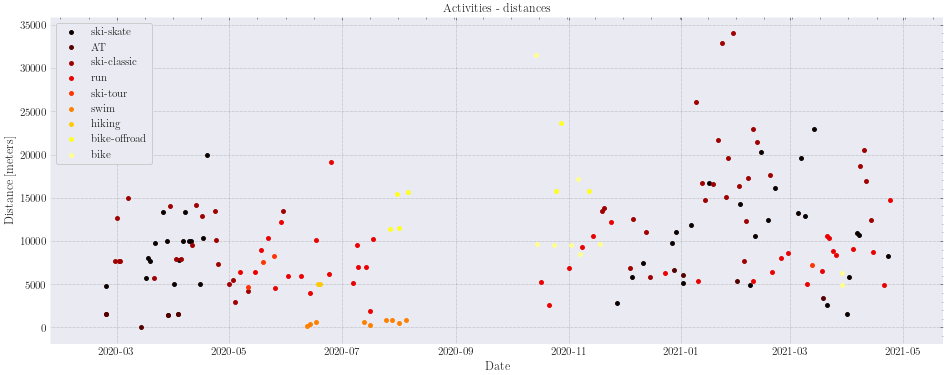

In [10]:
acts = tuple(activities)

z = range(1,len(acts))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(acts))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

plt.figure(figsize=(16,6))
for i in range(len(acts)):
    index = data["Activity"] == acts[i]
    plt.scatter(data["Date"][index], data["Distance"][index], s=15, color=scalarMap.to_rgba(i), label=acts[i])

plt.xlabel("Date")
plt.ylabel("Distance [meters]")
plt.title("Activities - distances")
plt.legend(loc="upper left")
plt.show()

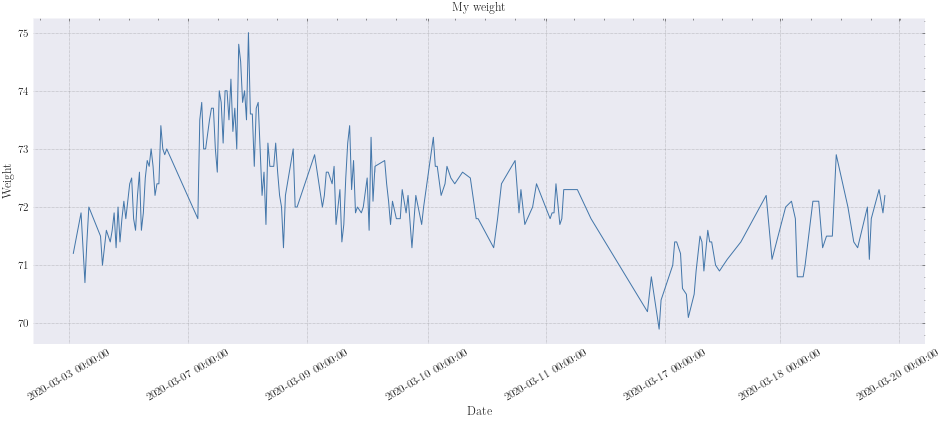

In [11]:
plt.figure(figsize=(16,6))
ax = sns.lineplot(x='Date', y='Weight', data=weight)
ax.set_xticklabels(weight["Date"], rotation=30)
plt.title("My weight")
plt.show()

In [12]:
p = figure(plot_width=1100, plot_height=400, x_axis_type="datetime", x_axis_label="Dato", y_axis_label="Meter")
color_map = CategoricalColorMapper(factors=data["Activity"].unique(), palette=Spectral9)
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Location", "@Location"),
        ("Distance[m]", "@Distance"),
        ("Activity", "@Activity"),
        ("Ascent", "@Elevation"),
    ],
)
p.add_tools(hover)
p.circle('Date', 'Distance', size=7, fill_alpha=0.2, color={"field": "Activity", "transform": color_map}, legend='Activity', source=data)
p.legend.location = "top_left"
show(p)

In [13]:
p = figure(plot_width=1000, plot_height=400, x_axis_type="datetime", x_axis_label="Dato", y_axis_label="Kilometer", title="Cumulative distance")
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Activity", "@Activity"),
        ("Daily [m]", "@Distance"),
        ("Total [km]", "@distance_cumsum"),
    ],
)
p.add_tools(hover)
p.line('Date', 'distance_cumsum', source=data)
show(p)

In [14]:
source = ColumnDataSource(weight)
p = figure(plot_width = 1100, plot_height = 400, x_axis_type = "datetime", title="My weight")
p.line('Date', 'Weight', source = source)
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Weight [kg]", "@Weight"),
    ],
)
p.add_tools(hover)
show(p)

In [15]:
elsa_born = date(2019, 10, 11)
today = date.today()
days = (today - elsa_born).days
weeks = days // 7
print("dager: ", days)
print("uker: ", weeks)
age = relativedelta(today, elsa_born)
print(age.months, "maneder,", age.days, "dager")

dager:  561
uker:  80
6 maneder, 13 dager


In [16]:
def growth_func(x,a,b,c):
    func = a*(1 - np.exp(-b*x))+c
    return func

In [17]:
from scipy.optimize import curve_fit

date0 = elsa_weight["Date"].iloc[0]
dateN = elsa_weight["Date"].iloc[-1]
new_idx = pd.date_range(date0, dateN)
new_idx = pd.Index(new_idx, name="Date")
elsa_indexed = elsa_weight.set_index("Date").reindex(new_idx)

# Interpolate missing weights
D = elsa_indexed.interpolate()
D = D.reset_index()
x = D.index.to_numpy() + 108
y = D["Weight"].to_numpy()

x_data = np.linspace(0,len(x)-1,len(x))
popt, pcov = curve_fit(growth_func, x_data, y)

/Users/ola/.virtualenvs/EiT/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/ola/.virtualenvs/EiT/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


In [18]:
y_est = growth_func(x_data, *popt)
est = pd.DataFrame(data={"Weight_est": y_est})
elsa_est = D.join(est)
weight_t_n = growth_func(2000, *popt)

In [19]:
g = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="Elsa's weight")
g.line('Date', 'Weight', source=elsa_est, legend_label="Measured")
g.line('Date', 'Weight_est', source=elsa_est, color="red", legend_label="Estimated")
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Weight [kg]", "@Weight"),
    ],
)
g.legend.location = "top_left"
g.add_tools(hover)
show(g)

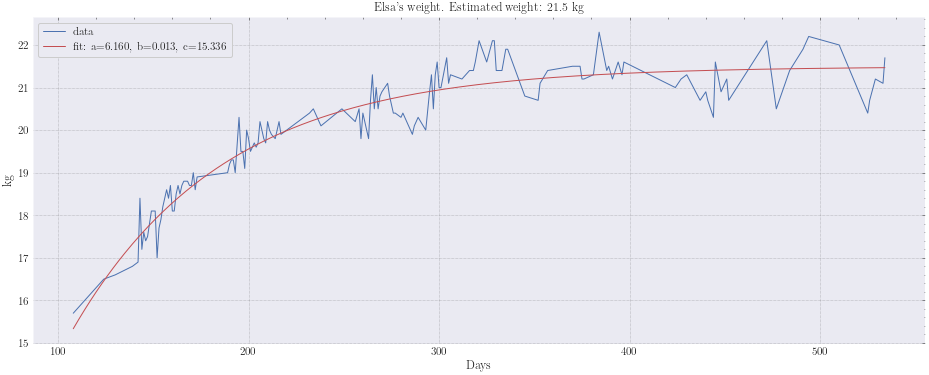

In [20]:
plt.figure(figsize=(16,6))
plt.plot(x, y, 'b-', label='data')
plt.plot(x, y_est, 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.xlabel("Days")
plt.ylabel("kg")
plt.title(f"Elsa's weight. Estimated weight: {round(weight_t_n, 2)} kg")
plt.show()